**Material Didático - Disciplina 0440221 - Geoprocessamento (2025)**
**Professores: André Negrão, Daniel Santos, Luizemara Szameitat**

# **Imagens de satélite: obtenção de dados e montar mosaico**

OBJETIVO DA AULA: Exercitar a busca e obtenção de imagens para uso em sensoriamento remoto para diversos fins.

* Nesta versão de código, não é possível executar para as bandas todas de uma vez pelo risco de exceder a memória do Colab. Então é preciso executar para 1 banda, e se precisar de mais, reconfigurar o código para a próxima banda.

Notebook disponível em https://github.com/lszam/geodata-processing/blob/main/remote_sensing


*Editor: Luizemara Szameitat - lszameitat.com - contato@lszameitat.com - 2025*

![Banner USP](https://raw.githubusercontent.com/lszam/geofex/main/assets/img/banner_usp.png)


# **PASSO ZERO - Configurar variáveis ✍️📝🧭**

In [1]:
# Área de interesse (AOI)

shapefile_path = "AreaTotal.shp" # NOME DO SHAPEFILE COM A AREA DE ESTUDO, EM COORDENADAS LAT LONG EPSG:4326


In [2]:
# Upload dos arquivos do shapefile da área

from google.colab import files
uploaded = files.upload()


Saving AreaTotal.cpg to AreaTotal.cpg
Saving AreaTotal.dbf to AreaTotal.dbf
Saving AreaTotal.prj to AreaTotal.prj
Saving AreaTotal.shp to AreaTotal.shp
Saving AreaTotal.shx to AreaTotal.shx


In [3]:
# Bandas a baixar
band_list = ["SR_B4","SR_B3","SR_B2"] # 👈 BANDAS ESCOLHIDAS

# **EXECUÇÃO - OBTER IMAGENS 👨‍💻**

## 1. Instalar pacotes no ambiente

In [8]:
!apt-get install -y gdal-bin

!pip install pystac_client planetary_computer rasterio geopandas matplotlib tqdm -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.6.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


Importar pacotes que serão usados

In [9]:
from datetime import datetime
from pystac_client import Client
import planetary_computer as pc
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from shapely.geometry import shape, Polygon
import matplotlib.pyplot as plt

import os
import gc
import requests

from rasterio.warp import calculate_default_transform, reproject#, Resampling
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt
import glob

from rasterio.enums import Resampling

## 2. Selecionar imagens

In [13]:
import geopandas as gpd

aoi_gdf = gpd.read_file(shapefile_path)
aoi_gdf = aoi_gdf.to_crs(epsg=4326)

# Initialize coords to an empty list
coords = []

# Check for valid geometries before accessing
if aoi_gdf.geometry.iloc[0] is not None and aoi_gdf.geometry.iloc[0].is_valid:
    geom = aoi_gdf.geometry.iloc[0]
    coords = list(geom.exterior.coords)
else:
    print("Error: Invalid or missing geometry for the first feature.")
    # Handle the case where the geometry is invalid or missing
    # You can either skip the feature, try to repair the geometry,
    # or provide default coordinates for the AOI


# 1. Conectar ao catálogo
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# 2. Definir a área de interesse (AOI)

aoi = {
    "type": "Polygon",
    "coordinates": [coords]
}

print(aoi)

{'type': 'Polygon', 'coordinates': [[(-49.50196079141588, -23.997647055491928), (-47.49803921507908, -23.997647055491928), (-47.493707249718135, -24.999404925282896), (-49.50196079141588, -25.010588235859434), (-49.50196079141588, -23.997647055491928)]]}


Coleções disponíveis neste repositório (Microsoft Planetary Computer)

In [14]:
collections = catalog.get_collections()
for item in collections:
  print(item)

<CollectionClient id=daymet-annual-pr>
<CollectionClient id=daymet-daily-hi>
<CollectionClient id=3dep-seamless>
<CollectionClient id=3dep-lidar-dsm>
<CollectionClient id=fia>
<CollectionClient id=sentinel-1-rtc>
<CollectionClient id=gridmet>
<CollectionClient id=daymet-annual-na>
<CollectionClient id=daymet-monthly-na>
<CollectionClient id=daymet-annual-hi>
<CollectionClient id=daymet-monthly-hi>
<CollectionClient id=daymet-monthly-pr>
<CollectionClient id=gnatsgo-tables>
<CollectionClient id=hgb>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=terraclimate>
<CollectionClient id=nasa-nex-gddp-cmip6>
<CollectionClient id=gpm-imerg-hhr>
<CollectionClient id=gnatsgo-rasters>
<CollectionClient id=3dep-lidar-hag>
<CollectionClient id=io-lulc-annual-v02>
<CollectionClient id=goes-cmi>
<CollectionClient id=conus404>
<CollectionClient id=3dep-lidar-intensity>
<CollectionClient id=3dep-lidar-pointsourceid>
<CollectionClient id=mtbs>
<CollectionCli

Existem 26 imagens pré-selecionadas


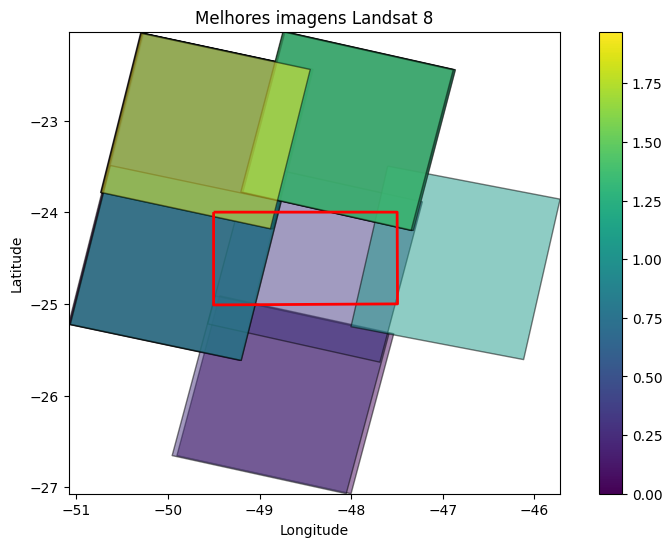

In [15]:
# 3. Buscar imagens Landsat 8 (filtro nuvens e data)
search = catalog.search(
    filter_lang="cql2-json",
    filter={
        "op": "and",
        "args": [
            {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
            {"op": "<", "args": [{"property": "eo:cloud_cover"}, 2]}, # 👈 escolher % de nuvens
            {"op": "=", "args": [{"property": "collection"}, "landsat-8-c2-l2"]}, # 👈 escolher LANDSAT
            {"op": ">", "args": [{"property": "datetime"}, "2020-01-01T00:00:00Z"]},
            {"op": "<", "args": [{"property": "datetime"}, "2022-01-01T23:59:59Z"]}
        ]
    }
)

# 4. Obter e ordenar por menor cobertura de nuvem
items = list(search.items())
items_sorted = sorted(items, key=lambda item: item.properties.get("eo:cloud_cover", 100))

# 5. Selecionar as melhores
best_items = items_sorted[:50] # 👈 escolher número de imagens listadas

print(f"Existem {len(best_items)} imagens pré-selecionadas")

# 6. Gerar GeoDataFrame dos footprints
geoms = [shape(item.geometry) for item in best_items]
gdf = gpd.GeoDataFrame({
    "cloud_cover": [item.properties["eo:cloud_cover"] for item in best_items],
    "datetime": [item.properties["datetime"] for item in best_items]
}, geometry=geoms, crs="EPSG:4326")

# 7. AOI como GeoDataFrame
aoi_geom = Polygon(aoi['coordinates'][0])
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geom], crs="EPSG:4326")

# 8. Plotar localização das imagens encontradas, cores para o "cloud_cover"
fig, ax = plt.subplots(figsize=(10, 6))
# Plotar localização das imagens
gdf.plot(ax=ax, column="cloud_cover", legend=True, cmap="viridis", alpha=0.5, edgecolor='black')
# Plotar a área de interesse (AOI)
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
# Definir os limites do gráfico manualmente com base na geometria
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')

plt.title("Melhores imagens Landsat 8")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()




Verificar como as imagens se sobrepõem para evitar redundância

In [16]:
# Reprojetar para UTM 23S (projeção métrica em metros)
gdf_proj = gdf.to_crs("EPSG:31983")

# Calcular área no CRS projetado (em m²)
gdf_proj["area"] = gdf_proj.geometry.area

# Identificar quais imagens manter
keep_indexes = []

for i, geom_i in enumerate(gdf_proj.geometry):
    to_keep = True
    for j in range(i):
        geom_j = gdf_proj.geometry[j]
        intersection = geom_i.intersection(geom_j)
        if intersection.is_empty:
            continue
        overlap_ratio = intersection.area / geom_i.area
        if overlap_ratio > 0.30:  # 👈 escolher taxa de sobreposição
            to_keep = False
            break
    if to_keep:
        keep_indexes.append(i)

# Filtrar as imagens não redundantes
gdf_reduzido = gdf.iloc[keep_indexes].copy()
print(f"{len(gdf_reduzido)} imagens mantidas de {len(gdf)} após remover sobreposições")
print("\nVariável gdf_reduzido:\n", gdf_reduzido)


# Garantir que o GeoDataFrame das imagens reduzidas está no mesmo CRS da AOI
gdf_reduzido = gdf_reduzido.to_crs("EPSG:4326")
aoi_gdf = aoi_gdf.to_crs("EPSG:4326")


6 imagens mantidas de 26 após remover sobreposições

Variável gdf_reduzido:
     cloud_cover                     datetime  \
0          0.00  2021-08-20T13:17:17.408142Z   
1          0.00  2021-08-20T13:16:53.462034Z   
5          0.02  2020-08-10T13:10:30.764058Z   
7          0.04  2020-04-04T13:11:00.164152Z   
14         0.33  2020-07-09T13:10:46.551515Z   
21         1.07  2020-05-31T13:04:15.007728Z   

                                             geometry  
0   POLYGON ((-50.64764 -23.48789, -48.78246 -23.8...  
1   POLYGON ((-50.29158 -22.04505, -48.4461 -22.43...  
5   POLYGON ((-48.72533 -22.02769, -46.86486 -22.4...  
7   POLYGON ((-49.43582 -24.91106, -47.53468 -25.3...  
14  POLYGON ((-49.10187 -23.46981, -47.22262 -23.8...  
21  POLYGON ((-47.60081 -23.49551, -45.71826 -23.8...  



Variável gdf_reduzido:
     cloud_cover                     datetime  \
0          0.00  2021-08-20T13:17:17.408142Z   
1          0.00  2021-08-20T13:16:53.462034Z   
5          0.02  2020-08-10T13:10:30.764058Z   
7          0.04  2020-04-04T13:11:00.164152Z   
14         0.33  2020-07-09T13:10:46.551515Z   
21         1.07  2020-05-31T13:04:15.007728Z   

                                             geometry filename  
0   POLYGON ((-50.64764 -23.48789, -48.78246 -23.8...    img_1  
1   POLYGON ((-50.29158 -22.04505, -48.4461 -22.43...    img_2  
5   POLYGON ((-48.72533 -22.02769, -46.86486 -22.4...    img_3  
7   POLYGON ((-49.43582 -24.91106, -47.53468 -25.3...    img_4  
14  POLYGON ((-49.10187 -23.46981, -47.22262 -23.8...    img_5  
21  POLYGON ((-47.60081 -23.49551, -45.71826 -23.8...    img_6  


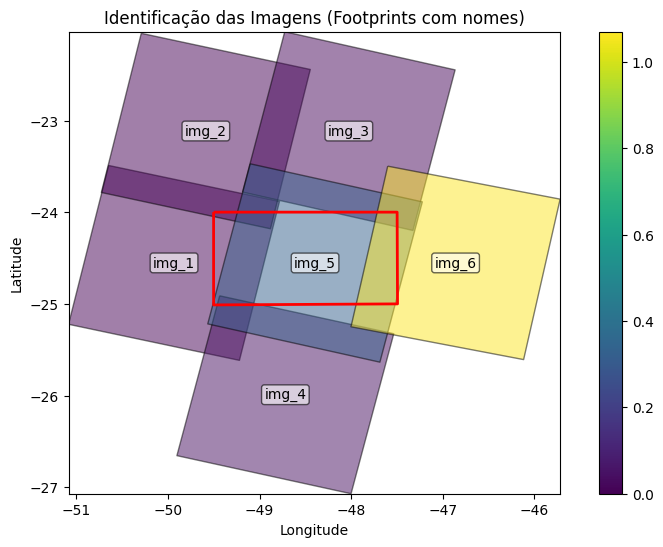

In [17]:
# Plotar os footprints mantidos

gdf_reduzido["filename"] = [f"img_{i+1}" for i in range(len(gdf_reduzido))]

print("\nVariável gdf_reduzido:\n", gdf_reduzido)

fig, ax = plt.subplots(figsize=(10, 6))

gdf_reduzido.plot(ax=ax, column="cloud_cover", legend=True, cmap="viridis", alpha=0.5, edgecolor='black')
aoi_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2)

for idx, row in gdf_reduzido.iterrows():
    centroid = row.geometry.centroid
    label = row["filename"]
    ax.text(centroid.x, centroid.y, label, fontsize=10, ha='center', va='center', color='black',
            bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.2'))

xmin, ymin, xmax, ymax = gdf_reduzido.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')

plt.title("Identificação das Imagens (Footprints com nomes)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## 3. Baixar imagens selecionadas

In [18]:
# Exibir bandas das imagens listadas em gdf_reduzido
gdf_reduzido = gdf_reduzido.reset_index(drop=True)

for idx, row in gdf_reduzido.iterrows():
    item = best_items[ keep_indexes[idx] ]
    print(f"Bandas disponíveis para a imagem {row['filename']}:")
    for key, asset in item.assets.items():
        print(f"- {key}: {asset.href}")

Bandas disponíveis para a imagem img_1:
- ANG: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/221/077/LC08_L2SP_221077_20210820_20210827_02_T1/LC08_L2SP_221077_20210820_20210827_02_T1_ANG.txt
- SR_B1: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/221/077/LC08_L2SP_221077_20210820_20210827_02_T1/LC08_L2SP_221077_20210820_20210827_02_T1_SR_B1.TIF
- SR_B2: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/221/077/LC08_L2SP_221077_20210820_20210827_02_T1/LC08_L2SP_221077_20210820_20210827_02_T1_SR_B2.TIF
- SR_B3: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/221/077/LC08_L2SP_221077_20210820_20210827_02_T1/LC08_L2SP_221077_20210820_20210827_02_T1_SR_B3.TIF
- SR_B4: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/221/077/LC08_L2SP_221077_20210820_20210827_02_T1/LC08_L2SP_221077_20210820_20210827_02_T1

Com a lista de bandas em mãos, definimos quais bandas serão baixadas

In [19]:
# Bandas a baixar
# band_list = ["SR_B4","SR_B3","SR_B2"] # 👈 BANDAS ESCOLHIDAS

In [20]:
# Pasta para salvar os arquivos
os.makedirs("/content/landsat", exist_ok=True)

# ===================== Baixar os itens de gdf_reduzido =====================

# Padronizar as datas para comparar imagens da mesma época
datetimes_reduzidas = set(pd.to_datetime(gdf_reduzido["datetime"]).dt.strftime("%Y-%m-%dT%H:%M:%S"))

# Selecionar apenas os itens com datetime correspondente
selected_items = [
    item for item in best_items
    if pd.to_datetime(item.properties["datetime"]).strftime("%Y-%m-%dT%H:%M:%S") in datetimes_reduzidas
]

for i, item in enumerate(selected_items):
    signed = pc.sign_item(item)
    for band_name, asset in signed.assets.items():
        if band_name in band_list:
            url = asset.href
            out_path = f"/content/landsat/img_{i+1}_{band_name}.tif"
            if not os.path.exists(out_path):
                print(f"Baixando {band_name} da imagem {i+1}...")
                r = requests.get(url, stream=True)
                with open(out_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)


Baixando SR_B2 da imagem 1...
Baixando SR_B3 da imagem 1...
Baixando SR_B4 da imagem 1...
Baixando SR_B2 da imagem 2...
Baixando SR_B3 da imagem 2...
Baixando SR_B4 da imagem 2...
Baixando SR_B2 da imagem 3...
Baixando SR_B3 da imagem 3...
Baixando SR_B4 da imagem 3...
Baixando SR_B2 da imagem 4...
Baixando SR_B3 da imagem 4...
Baixando SR_B4 da imagem 4...
Baixando SR_B2 da imagem 5...
Baixando SR_B3 da imagem 5...
Baixando SR_B4 da imagem 5...
Baixando SR_B2 da imagem 6...
Baixando SR_B3 da imagem 6...
Baixando SR_B4 da imagem 6...


Vamos verificar a resolução espacial utilizando uma das imagens:

In [21]:
print(f"Resolução espacial para img_1_{band_list[0]}.tif:", rasterio.open(f"/content/landsat/img_1_{band_list[0]}.tif").res)


Resolução espacial para img_1_SR_B4.tif: (30.0, 30.0)


Exibir imagens selecionadas e baixadas

Exibindo /content/landsat/img_3_SR_B4.tif...


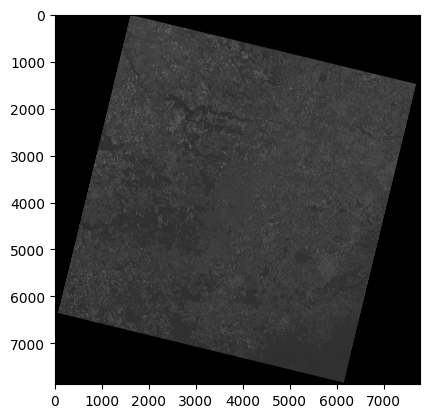

Exibindo /content/landsat/img_4_SR_B3.tif...


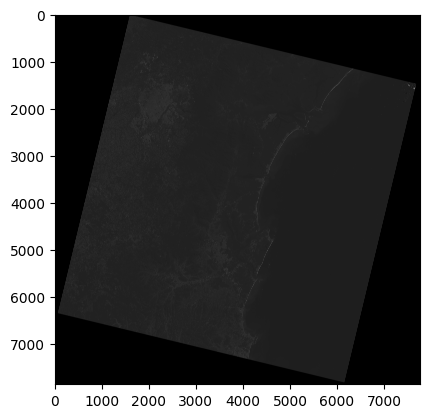

Exibindo /content/landsat/img_3_SR_B2.tif...


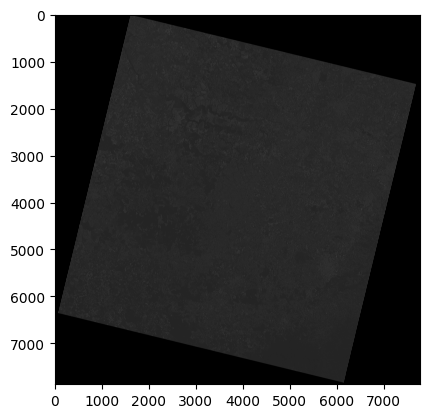

Exibindo /content/landsat/img_6_SR_B2.tif...


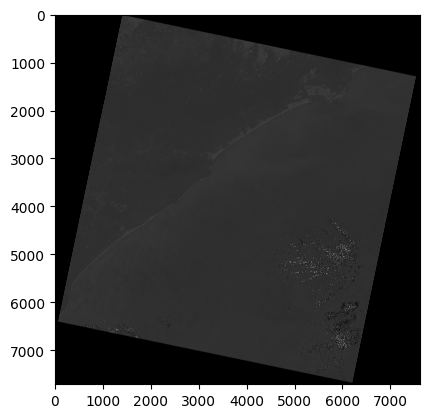

Exibindo /content/landsat/img_2_SR_B4.tif...


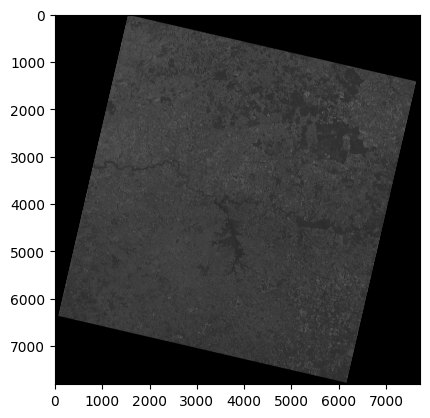

Exibindo /content/landsat/img_4_SR_B4.tif...


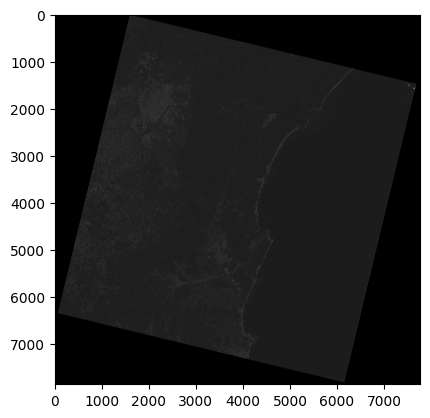

Exibindo /content/landsat/img_1_SR_B3.tif...


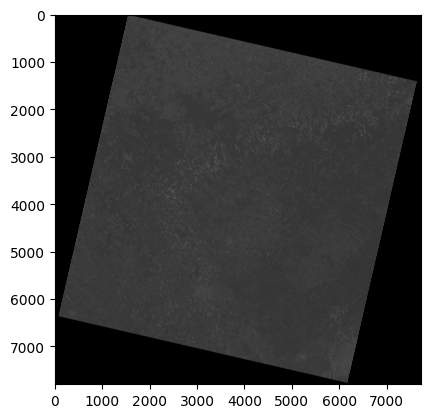

Exibindo /content/landsat/img_2_SR_B3.tif...


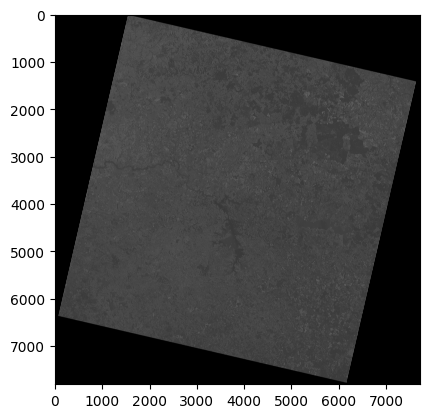

Exibindo /content/landsat/img_5_SR_B4.tif...


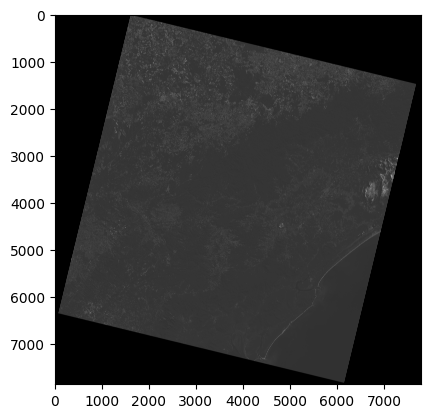

Exibindo /content/landsat/img_3_SR_B3.tif...


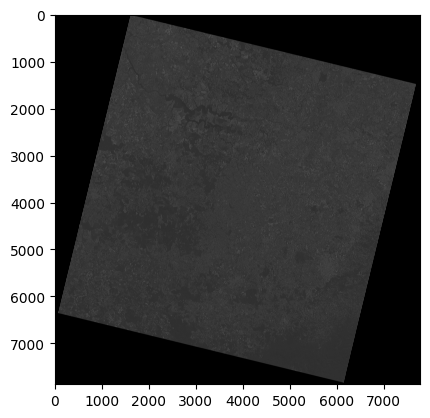

Exibindo /content/landsat/img_4_SR_B2.tif...


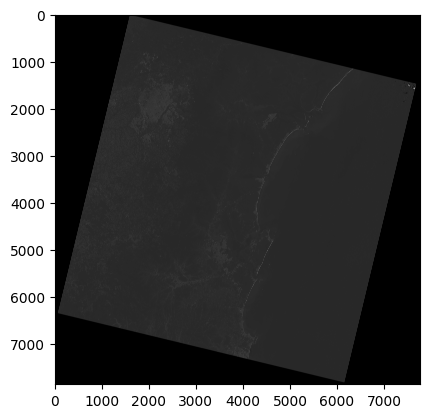

Exibindo /content/landsat/img_6_SR_B4.tif...


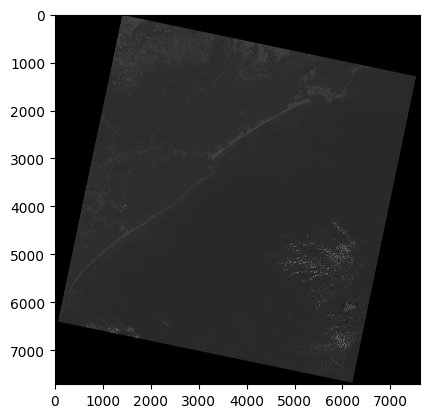

Exibindo /content/landsat/img_1_SR_B2.tif...


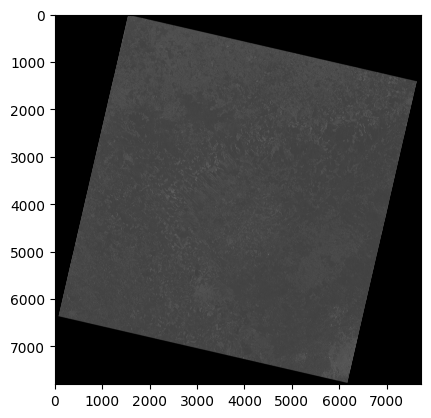

Exibindo /content/landsat/img_5_SR_B2.tif...


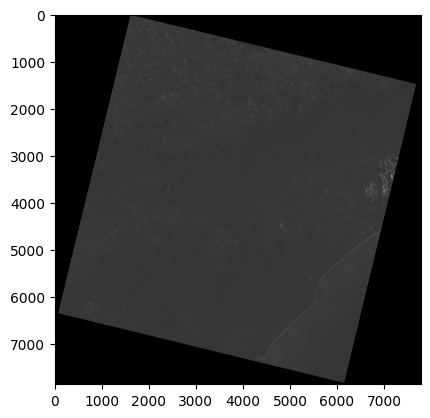

Exibindo /content/landsat/img_1_SR_B4.tif...


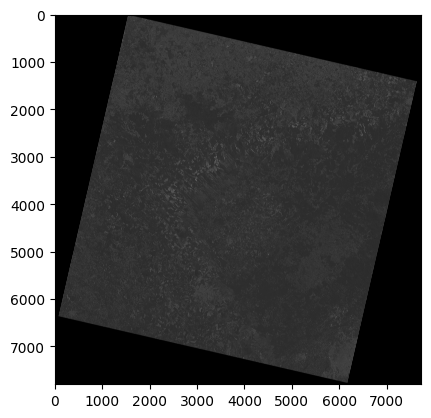

Exibindo /content/landsat/img_5_SR_B3.tif...


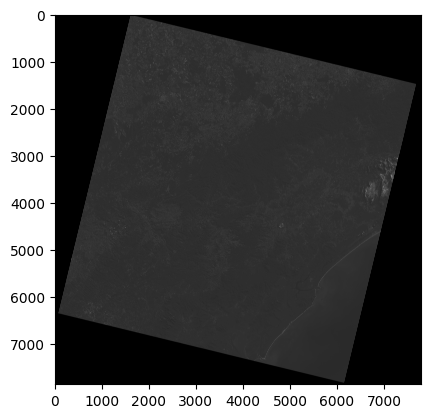

Exibindo /content/landsat/img_6_SR_B3.tif...


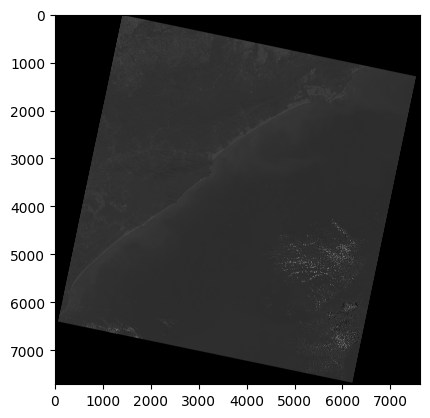

Exibindo /content/landsat/img_2_SR_B2.tif...


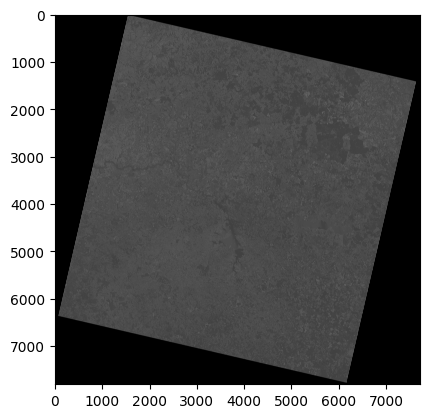

In [22]:
# Exibir imagens selecionadas e baixadas
from rasterio.plot import show

image_files = glob.glob("/content/landsat/*.tif")

for image_file in image_files:
    try:
        with rasterio.open(image_file) as src:
            image = src.read(1)  # 👈 lendo a primeira banda (única, neste caso!)
            print(f"Exibindo {image_file}...")
            show(image, cmap='gray')
    except Exception as e:
        print(f"Erro na exibição de {image_file}: {e}")


# **CORREÇÃO DE HISTOGRAMA 📊**

In [23]:
# Limpar a memória RAM
def show_memory_usage():
  import psutil
  process = psutil.Process(os.getpid())
  mem_info = process.memory_info()
  print(f"Current memory usage: {mem_info.rss / 1024**2:.2f} MB")

print("Memory usage before cleanup:")
show_memory_usage()
# Perform garbage collection
gc.collect()
print("\nMemory usage after cleanup:")
show_memory_usage()

Memory usage before cleanup:
Current memory usage: 1409.81 MB

Memory usage after cleanup:
Current memory usage: 798.34 MB


Percentis de img_1_SR_B4.tif : P2 = 7896.00, P98 = 12509.00

Imagem salva corrigida:


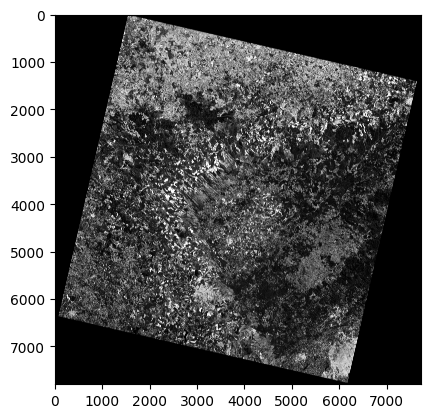

Percentis de img_2_SR_B4.tif : P2 = 8213.00, P98 = 14078.00

Imagem salva corrigida:


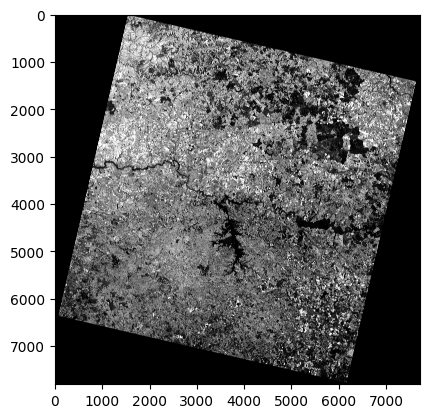

Percentis de img_3_SR_B4.tif : P2 = 7864.00, P98 = 13881.00

Imagem salva corrigida:


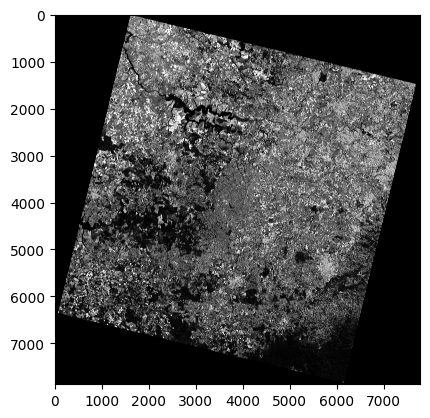

Percentis de img_4_SR_B4.tif : P2 = 7188.00, P98 = 12048.00

Imagem salva corrigida:


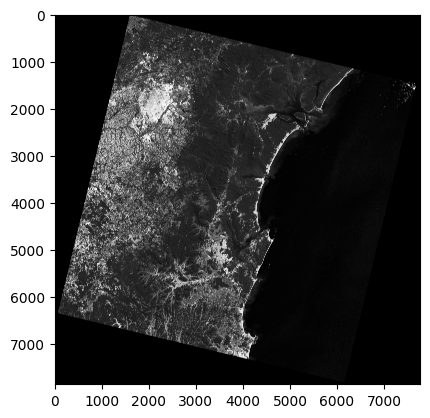

Percentis de img_5_SR_B4.tif : P2 = 7263.00, P98 = 11403.00

Imagem salva corrigida:


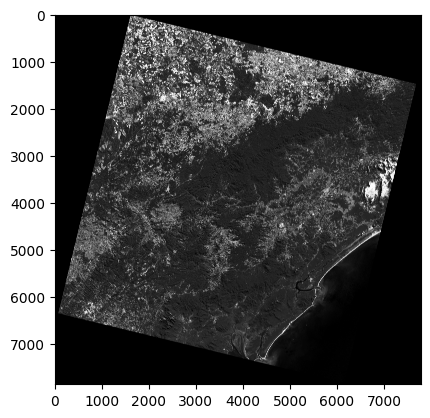

Percentis de img_6_SR_B4.tif : P2 = 7053.00, P98 = 11399.00

Imagem salva corrigida:


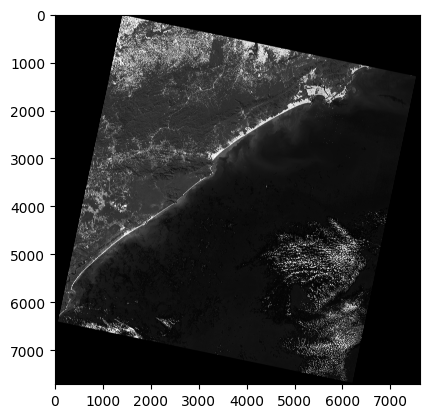

Percentis de img_1_SR_B3.tif : P2 = 8172.00, P98 = 11157.00

Imagem salva corrigida:


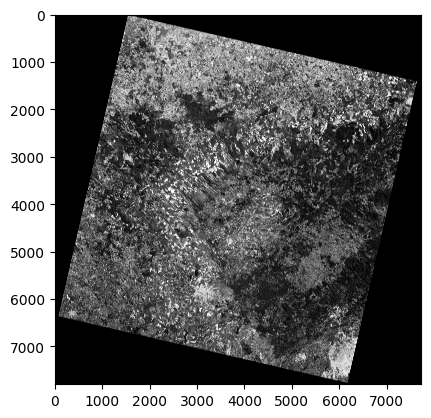

Percentis de img_2_SR_B3.tif : P2 = 8425.00, P98 = 11970.00

Imagem salva corrigida:


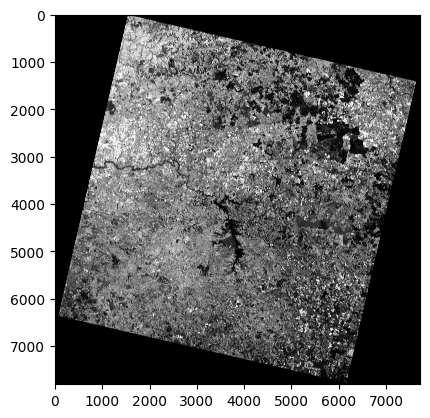

Percentis de img_3_SR_B3.tif : P2 = 8110.00, P98 = 11967.00

Imagem salva corrigida:


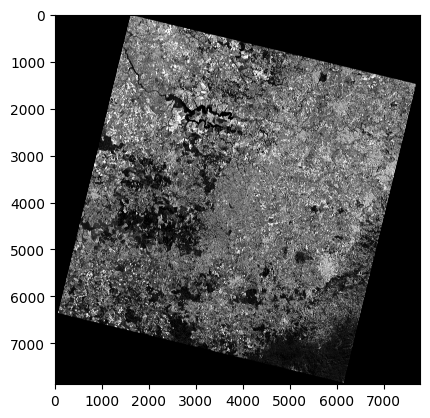

Percentis de img_4_SR_B3.tif : P2 = 7349.00, P98 = 11056.00

Imagem salva corrigida:


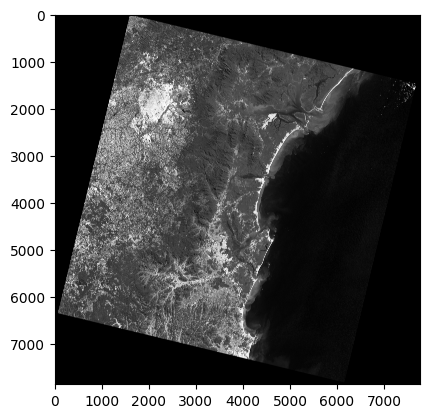

Percentis de img_5_SR_B3.tif : P2 = 7543.00, P98 = 10529.00

Imagem salva corrigida:


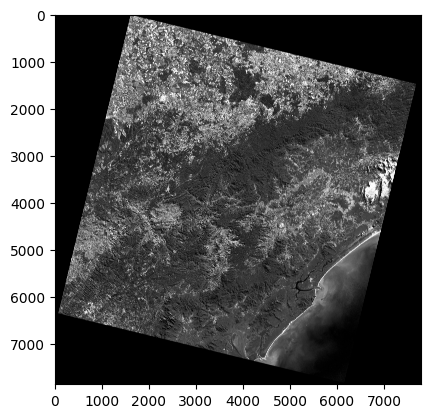

Percentis de img_6_SR_B3.tif : P2 = 7378.00, P98 = 10844.00

Imagem salva corrigida:


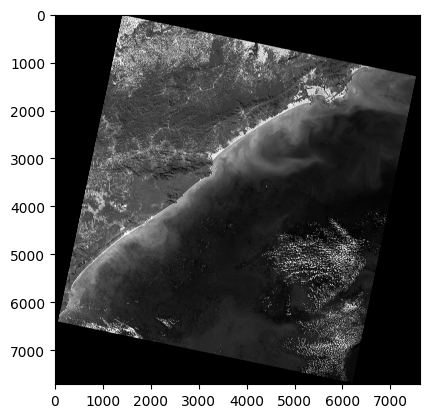

Percentis de img_1_SR_B2.tif : P2 = 7601.00, P98 = 9792.00

Imagem salva corrigida:


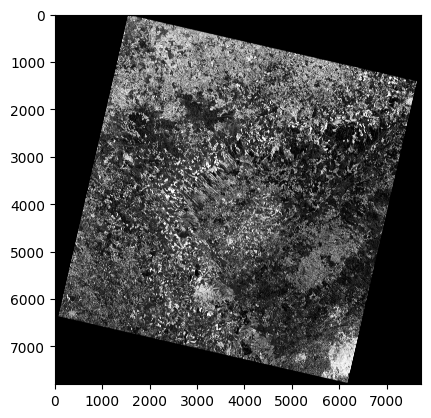

Percentis de img_2_SR_B2.tif : P2 = 7737.00, P98 = 10358.00

Imagem salva corrigida:


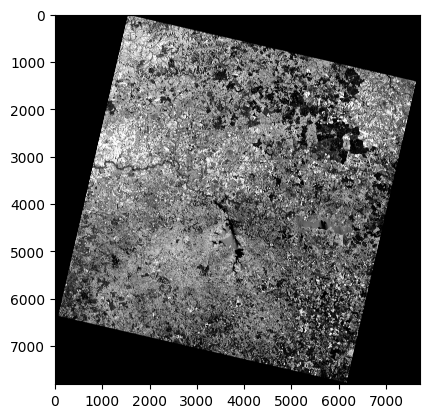

Percentis de img_3_SR_B2.tif : P2 = 7613.00, P98 = 10322.00

Imagem salva corrigida:


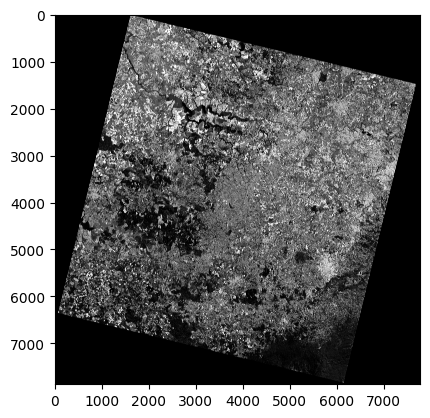

Percentis de img_4_SR_B2.tif : P2 = 7400.00, P98 = 9763.00

Imagem salva corrigida:


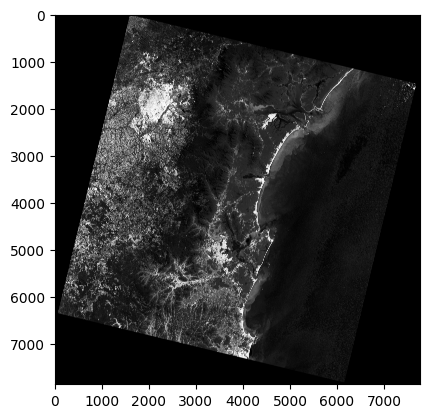

Percentis de img_5_SR_B2.tif : P2 = 7311.00, P98 = 9112.00

Imagem salva corrigida:


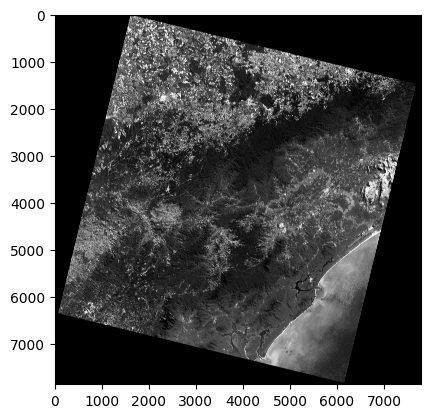

Percentis de img_6_SR_B2.tif : P2 = 7325.00, P98 = 9780.00

Imagem salva corrigida:


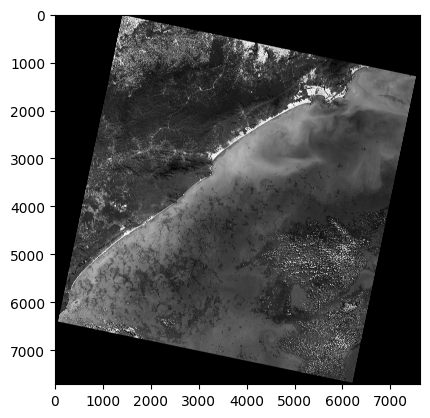

In [24]:
# Novo dicionário com chave = caminho do TIFF, e valor = (p2, p98, banda)
#                    perc_by_image[path] = (float(p2), float(p98), banda)

perc_by_image = {}

output_folder = "/content/"
os.makedirs(output_folder, exist_ok=True)

for banda in band_list:
    # TIFFs desta banda
    img_paths = sorted(glob.glob(f"/content/landsat/*{banda}.tif"))
    if not img_paths:
        print(f">>> Atenção! Nenhuma imagem encontrada para a banda {banda}")
        continue

    # Para cada imagem vai calcular os percentis
    for path in img_paths:
        with rasterio.open(path) as src:
            arr = src.read(1).astype("float32")

            valid = arr[np.isfinite(arr) & (arr > 0)]
            if valid.size == 0:
                print(f">>> Sem valores válidos em {os.path.basename(path)}")
                continue

            p2, p98 = np.percentile(valid, (2, 98))
            # armazena p2, p98 e banda
            perc_by_image[path] = (float(p2), float(p98), banda)
            print(f"Percentis de {os.path.basename(path)} : P2 = {p2:.2f}, P98 = {p98:.2f}")

            # Aplica correção por stretch com os percentis desta imagem
            stretched = np.clip((arr - p2) / (p98 - p2), 0, 1)

            # Preparar os metadados para escrita
            meta = src.meta.copy()
            meta.update({
                "dtype": "float32",
                "count": 1,
                "nodata": src.nodata
            })

            # Salvar TIFF do dado corrigido
            out_name = os.path.basename(path).replace(".tif", "_stretched.tif")
            out_path = os.path.join(output_folder, out_name)
            with rasterio.open(out_path, "w", **meta) as dst:
                dst.write(stretched, 1)

            with rasterio.open(out_path, "r") as dst:
                data = dst.read(1)
                print("\nImagem salva corrigida:")
                show(data, cmap='grey')

# **CRIAR IMAGEM RGB (B2, B3, B4 -> CORES NATURAIS) 🗺️**

Imagem bounds: BoundingBox(left=646185.0, bottom=-2836215.0, right=879615.0, top=-2600385.0)
AOI bounds:   [-49.50196079 -25.01058824 -47.49370725 -23.99764706]


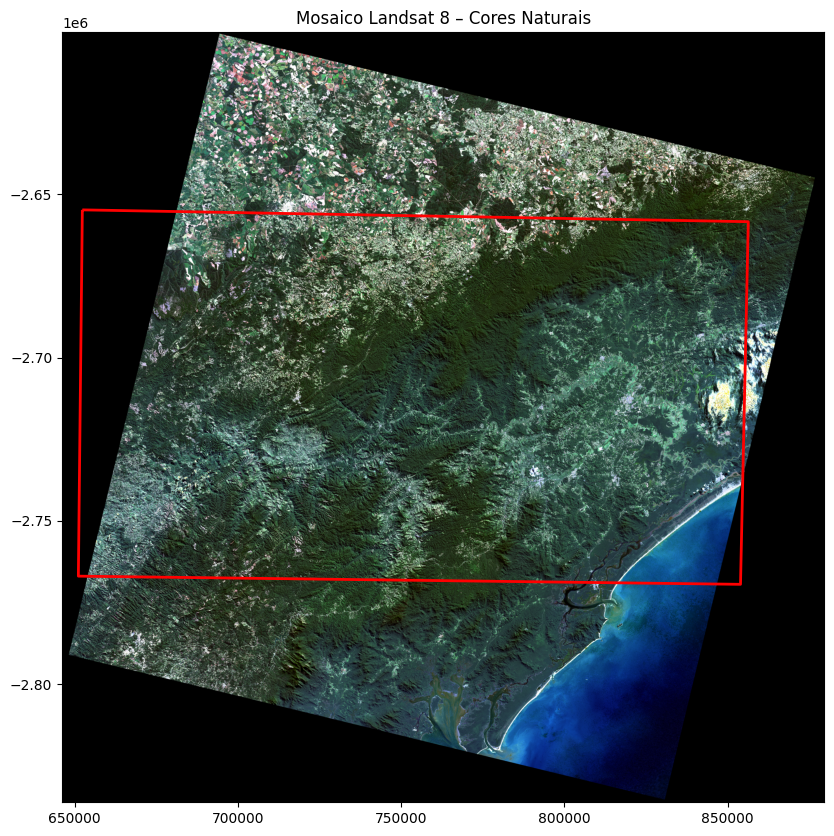

In [26]:
import rasterio

# Arquivos
b2_path = "/content/img_5_SR_B2_stretched.tif"
b3_path = "/content/img_5_SR_B3_stretched.tif"
b4_path = "/content/img_5_SR_B4_stretched.tif"

with rasterio.open(b2_path) as src_b2, \
     rasterio.open(b3_path) as src_b3, \
     rasterio.open(b4_path) as src_b4:

    B = src_b2.read(1)
    G = src_b3.read(1)
    R = src_b4.read(1)
    left, bottom, right, top = src_b2.bounds
    extent = [left, right, bottom, top]
    print("Imagem bounds:", src_b2.bounds)
    print("AOI bounds:  ", aoi_gdf.total_bounds)  # left, bottom, right, top
    with rasterio.open(b2_path) as src_b2:
      raster_crs = src_b2.crs
      aoi_gdf = aoi_gdf.to_crs(raster_crs)

# empilha em (rows, cols, bands)
RGB_image = np.dstack([R, G, B])  # h x w x 3
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(RGB_image, extent=extent, origin="upper")
aoi_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2)
ax.set_title("Mosaico Landsat 8 – Cores Naturais")
plt.show()

# **BAIXAR OS ARQUIVOS 🌎📁**

In [ ]:
from google.colab import files

# Get a list of all .tif files in the /content directory
tif_files = glob.glob('/content/*.tif')

# Download each file
for file in tif_files:
  files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>